In [99]:
import sqlite3
import torch
import torch.nn as nn
# import torch.optim as optim
# import numpy as np
import pandas as pd
# import random
from pathlib import Path
# from torch.utils.data import Dataset, DataLoader
# from sklearn.utils import resample
import matplotlib.pyplot as plt
import os

In [100]:
os.chdir(r"C:\Users\Alkor\VSCode\quote_prepare")

print(f"Текущая рабочая директория: {os.getcwd()}")

Текущая рабочая директория: C:\Users\Alkor\VSCode\quote_prepare


In [101]:
# Определение путей
db_path = Path(r'C:\Users\Alkor\gd\data_quote_db\RTS_futures_day_full.db')

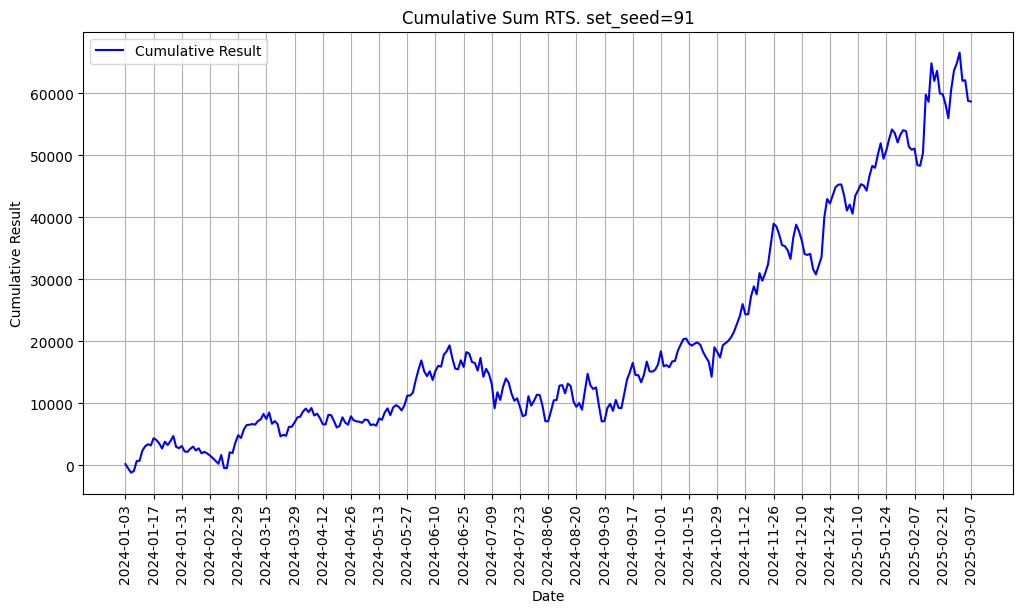

In [102]:
seed_val = 51

model_path = Path(fr"RTS_lih_bal_val85_test_PL/best_model_{seed_val}.pth")
# model_path = Path(fr"C:\Users\Alkor\VSCode\quote_prepare\RTS_lih_bal_val85_test_PL\best_model_{first_seed}.pth")

# === 1. ЗАГРУЗКА ДАННЫХ ИЗ БД (независимые данные) ===
with sqlite3.connect(db_path) as conn:
    df_fut = pd.read_sql_query(
        """
        SELECT TRADEDATE, OPEN, LOW, HIGH, CLOSE, VOLUME 
        FROM Day 
        WHERE TRADEDATE >= '2014-01-01' 
        ORDER BY TRADEDATE
        """,
        conn
    )


# === 2. ФУНКЦИЯ КОДИРОВАНИЯ СВЕЧЕЙ (ЛИХОВИДОВ) ===
def encode_candle(row):
    open_, low, high, close = row['OPEN'], row['LOW'], row['HIGH'], row['CLOSE']

    direction = 1 if close > open_ else (0 if close < open_ else 2)
    upper_shadow = high - max(open_, close)
    lower_shadow = min(open_, close) - low
    body = abs(close - open_)

    def classify_shadow(shadow, body):
        return 0 if shadow < 0.1 * body else (1 if shadow < 0.5 * body else 2)

    return f"{direction}{classify_shadow(upper_shadow, body)}{classify_shadow(lower_shadow, body)}"


df_fut['CANDLE_CODE'] = df_fut.apply(encode_candle, axis=1)

# === 3. ПРЕОБРАЗОВАНИЕ КОДОВ В ЧИСЛА ===
unique_codes = sorted(df_fut['CANDLE_CODE'].unique())
code_to_int = {code: i for i, code in enumerate(unique_codes)}
df_fut['CANDLE_INT'] = df_fut['CANDLE_CODE'].map(code_to_int)

window_size = 20

# === 4. ОПРЕДЕЛЕНИЕ МОДЕЛИ (ДОЛЖНА СОВПАДАТЬ С ОБУЧЕННОЙ) ===
class CandleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(CandleLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return self.sigmoid(x)

# === 5. ЗАГРУЗКА ОБУЧЕННОЙ МОДЕЛИ ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_path = Path("best_model_profit_loss_test.pth")  # Уже определено
model = CandleLSTM(vocab_size=len(unique_codes), embedding_dim=8, hidden_dim=32,
                    output_dim=1).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# === 6. ПРОГНОЗИРОВАНИЕ ===
predictions = []
with torch.no_grad():
    for i in range(len(df_fut) - window_size):
        sequence = torch.tensor(
            df_fut['CANDLE_INT'].iloc[i:i + window_size].values, dtype=torch.long
        ).unsqueeze(0).to(device)
        pred = model(sequence).item()
        predictions.append(1 if pred > 0.5 else 0)

# Заполняем колонку PREDICTION (первые window_size значений - NaN)
df_fut['PREDICTION'] = [None] * window_size + predictions

# # === 7. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ===
# predictions_file = Path(r"predictions_graph_RTS_01.csv")
# df_fut.to_csv(predictions_file, index=False)
# print(f"✅ Прогнозы сохранены в '{predictions_file}'")

# -------------------------------------------------------------------------------------
# # === 1. ЗАГРУЗКА ФАЙЛА И ОТБОР ПОСЛЕДНИХ 20% ===
# df = pd.read_csv(predictions_file)

# Выбор строк, где TRADEDATE больше 2024-01-01
df = df_fut[df_fut['TRADEDATE'] > '2024-01-01'].copy()
# df = df_fut.iloc[split:].copy()  # Берем последние 20%

# === 3. РАСЧЁТ РЕЗУЛЬТАТОВ ПРОГНОЗА ===
def calculate_result(row):
    if pd.isna(row["PREDICTION"]):  # Если NaN после сдвига
        return 0  # Можно удалить или оставить 0

    true_direction = 1 if row["CLOSE"] > row["OPEN"] else 0
    predicted_direction = row["PREDICTION"]

    difference = abs(row["CLOSE"] - row["OPEN"])
    return difference if true_direction == predicted_direction else -difference


df["RESULT"] = df.apply(calculate_result, axis=1)

# === 4. ПОСТРОЕНИЕ КУМУЛЯТИВНОГО ГРАФИКА ===
df["CUMULATIVE_RESULT"] = df["RESULT"].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df["TRADEDATE"], df["CUMULATIVE_RESULT"], label="Cumulative Result",
            color="b")
plt.xlabel("Date")
plt.ylabel("Cumulative Result")
plt.title(f"Cumulative Sum RTS. set_seed={first_seed}")
plt.legend()
plt.grid()

plt.xticks(df["TRADEDATE"][::10], rotation=90)
# # Сохранение графика в файл
# img_path = Path(fr"img_RTS_net_pips_test\s_{counter}_RTS.png")
# plt.savefig(img_path, dpi=300, bbox_inches='tight')
# print(f"✅ График сохранен в файл: '{img_path}' \n")
plt.show()


In [103]:
# Загружаем модель
model.load_state_dict(torch.load(model_path))
model.eval()

# Получение значения из последней строки колонки TRADEDATE
last_trade_date = df['TRADEDATE'].iloc[-1]

# Берем последние 20 свечей из df_fut
last_sequence = torch.tensor(
    df['CANDLE_INT'].iloc[-20:].values, dtype=torch.long
    ).unsqueeze(0).to(device)

# Предсказание
with torch.no_grad():
    probability_up = model(last_sequence).item()  # Вероятность роста
    probability_down = 1 - probability_up  # Вероятность падения

    direction = "📈 UP" if probability_up >= 0.5 else "📉 DOWN"

    print(f"Prediction: {direction}. {seed_val=}. {last_trade_date}")
    print(
        f"UP Probability: {probability_up:.2%}, \n"
        f"DOWN Probability: {probability_down:.2%}"
        )

Prediction: 📉 DOWN. seed_val=51. 2025-03-07
UP Probability: 45.78%, 
DOWN Probability: 54.22%


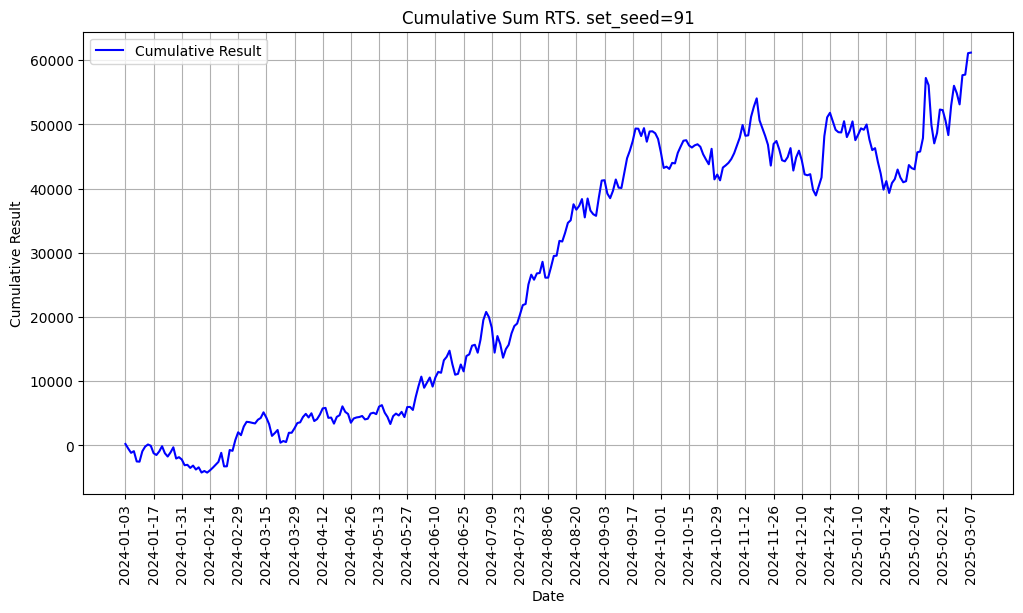

In [104]:
seed_val = 91

# model_path = Path(fr"/RTS_lih_bal_val85_test_PL/best_model_{first_seed}.pth")
model_path = Path(fr"C:\Users\Alkor\VSCode\quote_prepare\RTS_lih_bal_val85_test_PL\best_model_{seed_val}.pth")

# === 1. ЗАГРУЗКА ДАННЫХ ИЗ БД (независимые данные) ===
with sqlite3.connect(db_path) as conn:
    df_fut = pd.read_sql_query(
        """
        SELECT TRADEDATE, OPEN, LOW, HIGH, CLOSE, VOLUME 
        FROM Day 
        WHERE TRADEDATE >= '2014-01-01' 
        ORDER BY TRADEDATE
        """,
        conn
    )


# === 2. ФУНКЦИЯ КОДИРОВАНИЯ СВЕЧЕЙ (ЛИХОВИДОВ) ===
def encode_candle(row):
    open_, low, high, close = row['OPEN'], row['LOW'], row['HIGH'], row['CLOSE']

    direction = 1 if close > open_ else (0 if close < open_ else 2)
    upper_shadow = high - max(open_, close)
    lower_shadow = min(open_, close) - low
    body = abs(close - open_)

    def classify_shadow(shadow, body):
        return 0 if shadow < 0.1 * body else (1 if shadow < 0.5 * body else 2)

    return f"{direction}{classify_shadow(upper_shadow, body)}{classify_shadow(lower_shadow, body)}"


df_fut['CANDLE_CODE'] = df_fut.apply(encode_candle, axis=1)

# === 3. ПРЕОБРАЗОВАНИЕ КОДОВ В ЧИСЛА ===
unique_codes = sorted(df_fut['CANDLE_CODE'].unique())
code_to_int = {code: i for i, code in enumerate(unique_codes)}
df_fut['CANDLE_INT'] = df_fut['CANDLE_CODE'].map(code_to_int)

window_size = 20

# === 4. ОПРЕДЕЛЕНИЕ МОДЕЛИ (ДОЛЖНА СОВПАДАТЬ С ОБУЧЕННОЙ) ===
class CandleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(CandleLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return self.sigmoid(x)

# === 5. ЗАГРУЗКА ОБУЧЕННОЙ МОДЕЛИ ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_path = Path("best_model_profit_loss_test.pth")  # Уже определено
model = CandleLSTM(vocab_size=len(unique_codes), embedding_dim=8, hidden_dim=32,
                    output_dim=1).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# === 6. ПРОГНОЗИРОВАНИЕ ===
predictions = []
with torch.no_grad():
    for i in range(len(df_fut) - window_size):
        sequence = torch.tensor(
            df_fut['CANDLE_INT'].iloc[i:i + window_size].values, dtype=torch.long
        ).unsqueeze(0).to(device)
        pred = model(sequence).item()
        predictions.append(1 if pred > 0.5 else 0)

# Заполняем колонку PREDICTION (первые window_size значений - NaN)
df_fut['PREDICTION'] = [None] * window_size + predictions

# # === 7. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ===
# predictions_file = Path(r"predictions_graph_RTS_01.csv")
# df_fut.to_csv(predictions_file, index=False)
# print(f"✅ Прогнозы сохранены в '{predictions_file}'")

# -------------------------------------------------------------------------------------
# # === 1. ЗАГРУЗКА ФАЙЛА И ОТБОР ПОСЛЕДНИХ 20% ===
# df = pd.read_csv(predictions_file)

# Выбор строк, где TRADEDATE больше 2024-01-01
df = df_fut[df_fut['TRADEDATE'] > '2024-01-01'].copy()
# df = df_fut.iloc[split:].copy()  # Берем последние 20%

# === 3. РАСЧЁТ РЕЗУЛЬТАТОВ ПРОГНОЗА ===
def calculate_result(row):
    if pd.isna(row["PREDICTION"]):  # Если NaN после сдвига
        return 0  # Можно удалить или оставить 0

    true_direction = 1 if row["CLOSE"] > row["OPEN"] else 0
    predicted_direction = row["PREDICTION"]

    difference = abs(row["CLOSE"] - row["OPEN"])
    return difference if true_direction == predicted_direction else -difference


df["RESULT"] = df.apply(calculate_result, axis=1)

# === 4. ПОСТРОЕНИЕ КУМУЛЯТИВНОГО ГРАФИКА ===
df["CUMULATIVE_RESULT"] = df["RESULT"].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df["TRADEDATE"], df["CUMULATIVE_RESULT"], label="Cumulative Result",
            color="b")
plt.xlabel("Date")
plt.ylabel("Cumulative Result")
plt.title(f"Cumulative Sum RTS. set_seed={first_seed}")
plt.legend()
plt.grid()

plt.xticks(df["TRADEDATE"][::10], rotation=90)
# # Сохранение графика в файл
# img_path = Path(fr"img_RTS_net_pips_test\s_{counter}_RTS.png")
# plt.savefig(img_path, dpi=300, bbox_inches='tight')
# print(f"✅ График сохранен в файл: '{img_path}' \n")
plt.show()


In [105]:
# Загружаем модель
model.load_state_dict(torch.load(model_path))
model.eval()

# print(df)

# # Преобразование TRADEDATE в формат datetime (рекомендуется)
# df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])

# Получение значения из последней строки колонки TRADEDATE
last_trade_date = df['TRADEDATE'].iloc[-1]

# Берем последние 20 свечей из df
last_sequence = torch.tensor(
    df['CANDLE_INT'].iloc[-20:].values, dtype=torch.long
    ).unsqueeze(0).to(device)

# Предсказание
with torch.no_grad():
    probability_up = model(last_sequence).item()  # Вероятность роста
    probability_down = 1 - probability_up  # Вероятность падения

    direction = "📈 UP" if probability_up >= 0.5 else "📉 DOWN"

    print(f"Prediction: {direction}. {seed_val=}. {last_trade_date}")
    print(
        f"UP Probability: {probability_up:.2%}, \n"
        f"DOWN Probability: {probability_down:.2%}"
        )

Prediction: 📉 DOWN. seed_val=91. 2025-03-07
UP Probability: 36.27%, 
DOWN Probability: 63.73%
